In [39]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
import pandas as pd

In [40]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [41]:
# create a differenced series
def difference(dataset, interval=7):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

In [42]:
# invert differenced value
def inverse_difference(history, yhat, interval=7):
	return yhat + history[-interval]

In [43]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [44]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [45]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model


In [46]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

Arrivals to Italy
At iteration 1
51 48
Test RMSE: 1453.144
At iteration 2
99 48
Test RMSE: 1309.035
At iteration 3
147 48
Test RMSE: 1424.281
At iteration 4
195 48
Test RMSE: 1279.417
At iteration 5
243 48
Test RMSE: 1525.132
At iteration 6
291 48
Test RMSE: 159.462


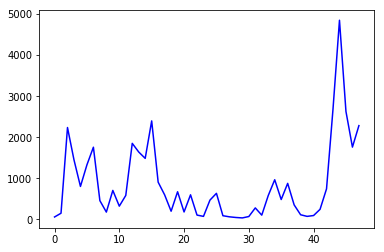

Arrivals to Greek Islands
At iteration 1
51 48
Test RMSE: 3567.381
At iteration 2
99 48
Test RMSE: 2577.240
At iteration 3
147 48
Test RMSE: 1231.191
At iteration 4
195 48
Test RMSE: 104.191
At iteration 5
243 48
Test RMSE: 99.022
At iteration 6
291 48
Test RMSE: 7.158


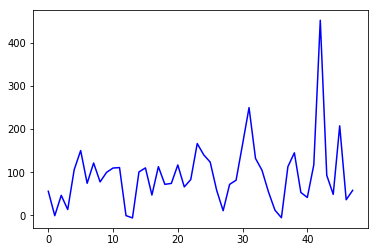

Departures to mainland Greece
At iteration 1
51 48
Test RMSE: 2763.146
At iteration 2
99 48
Test RMSE: 2168.277
At iteration 3
147 48
Test RMSE: 1069.383
At iteration 4
195 48
Test RMSE: 124.782
At iteration 5
243 48
Test RMSE: 37.870
At iteration 6
291 48
Test RMSE: 6.968


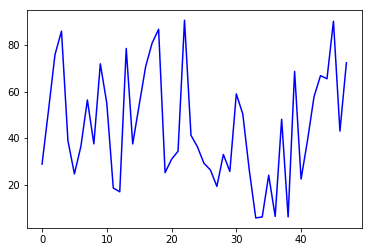

Arrivals to fYRoM
At iteration 1
51 48
Test RMSE: 3198.647
At iteration 2
99 48
Test RMSE: 1797.913
At iteration 3
147 48
Test RMSE: 215.843
At iteration 4
195 48
Test RMSE: 34.457
At iteration 5
243 48
Test RMSE: 51.952
At iteration 6
291 48
Test RMSE: 3.043


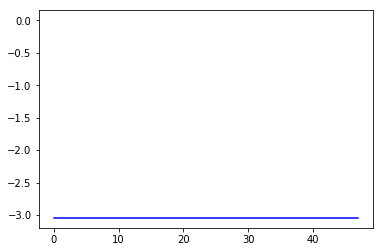

Arrivals to Serbia
At iteration 1
51 48
Test RMSE: 3092.053
At iteration 2
99 48
Test RMSE: 1712.846
At iteration 3
147 48
Test RMSE: 125.683
At iteration 4
195 48
Test RMSE: 173.940
At iteration 5
243 48
Test RMSE: 153.080
At iteration 6
291 48
Test RMSE: 7.376


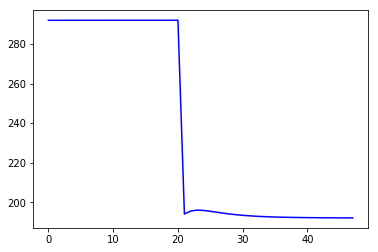

Arrivals to Croatia
At iteration 1
51 48
Test RMSE: 3033.819
At iteration 2
99 48
Test RMSE: 1783.729
At iteration 3
147 48
Test RMSE: 172.119
At iteration 4
195 48
Test RMSE: 36.208
At iteration 5
243 48
Test RMSE: 5.444
At iteration 6
291 48
Test RMSE: 24.084


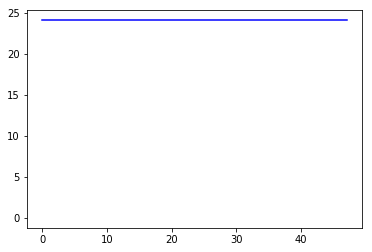

Arrivals to Hungary
At iteration 1
51 48
Test RMSE: 866.789
At iteration 2
99 48
Test RMSE: 149.225
At iteration 3
147 48
Test RMSE: 163.111
At iteration 4
195 48
Test RMSE: 114.597
At iteration 5
243 48
Test RMSE: 109.181
At iteration 6
291 48
Test RMSE: 8.697


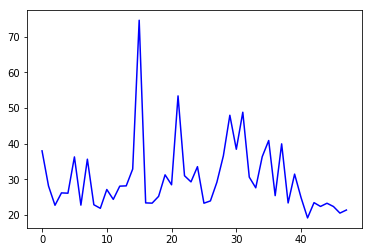

Arrivals to Slovenia
At iteration 1
51 48
Test RMSE: 3326.980
At iteration 2
99 48
Test RMSE: 1890.231
At iteration 3
147 48
Test RMSE: 164.953
At iteration 4
195 48
Test RMSE: 31.178
At iteration 5
243 48
Test RMSE: 12.803
At iteration 6
291 48
Test RMSE: 4.020


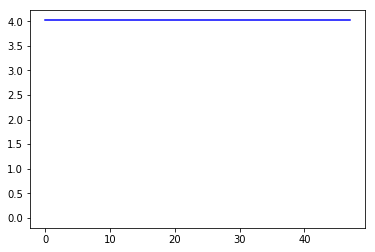

Arrivals to Austria
At iteration 1
51 48
Test RMSE: 3156.164
At iteration 2
99 48
Test RMSE: 1731.158
At iteration 3
147 48
Test RMSE: 186.445
At iteration 4
195 48
Test RMSE: 96.340
At iteration 5
243 48
Test RMSE: 79.031
At iteration 6
291 48
Test RMSE: 11.117


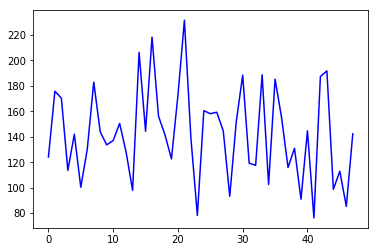

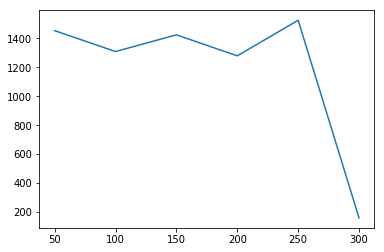

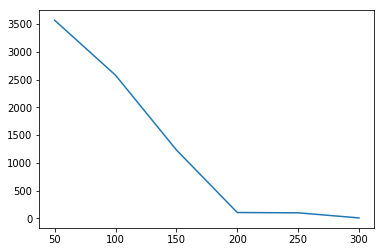

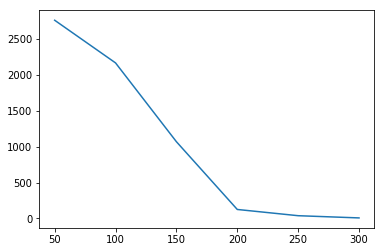

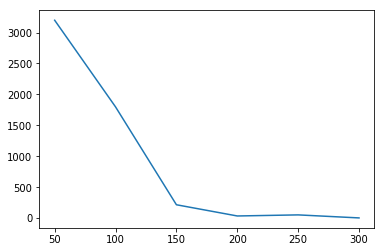

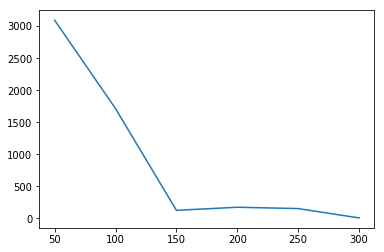

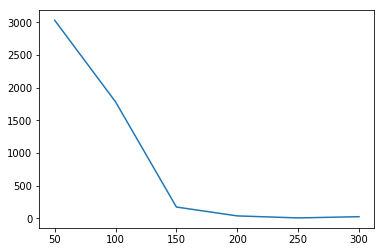

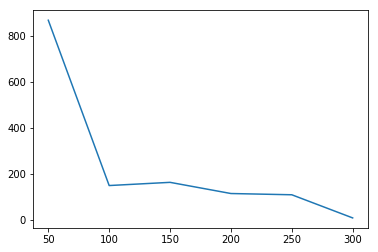

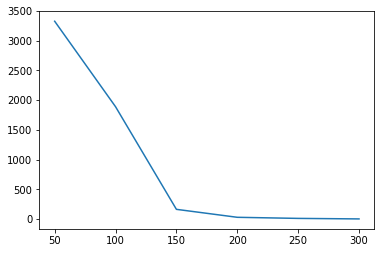

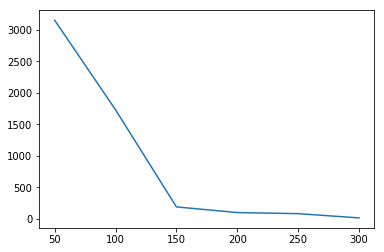

In [49]:
# load dataset
series = pd.read_csv('../Data/refugeedata.csv', index_col='Date', squeeze=True)
series = series.replace(',','',regex=True)
series = series.apply(pd.to_numeric)
series.interpolate(inplace=True)
i = 0
performance=[]
interval = [50,100,150,200,250,300]
column_names = ['Arrivals to Italy', 'Arrivals to Greek Islands','Departures to mainland Greece','Arrivals to fYRoM','Arrivals to Serbia','Arrivals to Croatia','Arrivals to Hungary','Arrivals to Slovenia','Arrivals to Austria']
for index,country in enumerate(column_names):
    #series = series['Arrivals to Greek Islands']
    raw_values = series[country].values
    diff_values = difference(raw_values, 1)
    print(column_names[index])
    index=index+1
    
    # transform data to be supervised learning
    supervised = timeseries_to_supervised(diff_values, 1)
    supervised_values = supervised.values
    # split data into train and test-sets
    
    #train, test = supervised_values[0:300], supervised_values[300:-1]
    #print (len(train))
    j = 50
    count = 0
    while (j<len(supervised_values)-1):
        count = count+1
        print ("At iteration {}".format(count))
        train = supervised_values[0:j+1]
        test = supervised_values[j+1:j+49]
        print (len(train), len(test))
        
    
        # transform data to be supervised learning
        supervised = timeseries_to_supervised(diff_values, 1)
        supervised_values = supervised.values
    
        # split data into train and test-sets
        #train, test = supervised_values[0:300], supervised_values[300:-1]
        #print (len(train))
    
        # transform the scale of the data
        scaler, train_scaled, test_scaled = scale(train, test)
    
        lstm_model = fit_lstm(train_scaled, 1, 1, 4)
        train_reshaped = train_scaled[:, 0]
        train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    
        lstm_model.predict(train_reshaped, batch_size=1)
    
    
        # walk-forward validation on the test data
        predictions = list()
        for i in range(len(test_scaled)):
        # make one-step forecast
            X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
            yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
            yhat = invert_scale(scaler, X, yhat)
        # invert differencing
            yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
            predictions.append(yhat)
            expected = raw_values[len(train) + i]
            #print('Date=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
        
    # report performance
        #print (raw_values[j+1:j+49], predictions)
        rmse = sqrt(mean_squared_error(raw_values[j+1:j+49], predictions))
        performance.append(rmse)
        print('Test RMSE: %.3f' % rmse)
        
        j = j+48

    
     #line plot of observed vs predicted

    pyplot.plot(raw_values[j+1:j+49], 'r',label = 'test')
    pyplot.plot(predictions, 'b',label = 'predicted')
    pyplot.show()
    pyplot.figure();
iter = 0
while (iter<len(performance)-1):
    perf = performance[iter:iter+6]
    pyplot.plot(interval,perf)
    pyplot.show();
    iter = iter+6

In [ ]:
iter = 0
while (iter<len(performance)-1):
    perf = performance[iter:iter+6]
    pyplot.plot(interval,perf)
    pyplot.show();
    iter = iter+6